# 01 Convolutional Neural Network(CNN)

# 02 CNN과 MLP

In [ ]:
# [예제 4-1] CIFAR-10 데이터를 이용해 Multi Layer Perceptron(MLP) 설계하기

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활요하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0+cu113  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
''' 3. MNIST 데이터 다운로드(Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "./data/CIFAR10",
                              train = True,
                              download = True,
                              transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "./data/CIFAR10/",
                              train = False,
                              transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


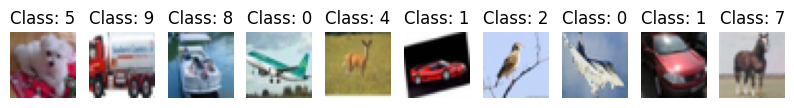

In [6]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
''' 6. MLP(Multi Layer Perceptron) 모델 설계하기 '''
class Net(nn.Module): # nn.Module 클래스 상속 -> 딥러닝 모델 관련 기본 함수를 포함
    def __init__(self): #  인스턴스 생성 시 지니게 되는 성질을 정의해주는 메서드
        super(Net, self).__init__() # nn.Module 내에 있는 매서드를 상속받아 이용
        self.fc1 = nn.Linear(32 * 32 * 3, 512) # 첫 번째 Fully Connected Layer 정의
        self.fc2 = nn.Linear(512, 256) # 두 번째 Fully Connected Layer 정의
        self.fc3 = nn.Linear(256, 10) # 세 번째 Fully Connected Layer 정의
    def forward(self, x): # Forward Propagation 정의
        x = x.view(-1, 32 * 32 * 3) # 2차원 데이터를 1차원 데이터로 변환 -> MLP 모델은 1차원의 벡터 값을 입력으로 받을 수 있음
        x = self.fc1(x)
        x = F.sigmoid(x) # 활성화 함수
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1) # 확률 값 계산. log_softmax를 사용하는 이유는 gradient 값을 좀 더 원활하게 계산하기 위해 
        return x

In [8]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [13]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train() # 모델을 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE) # 기존 정의한 장비에 할당
        label = label.to(DEVICE) # 기존 정의한 장비에 할당
        optimizer.zero_grad() # 기존 할당되어 있던 gradient 값 초기화
        output = model(image) # Forward propagation
        loss = criterion(output, label) # loss 계산
        loss.backward() # Backpropagation을 통해 계산된 gradient 값을 각 파라미터에 할당
        optimizer.step() # 파라미터 업데이트
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                  Epoch, batch_idx * len(image),
                  len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                  loss.item()))

In [14]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval() # 모델을 평가 상태로 지정
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): # 평가하는 단계에서 gradient를 통해 파라미터 값이 업데이트되는 현상을 방지
        for image, label in test_loader:
            image = image.to(DEVICE) # 기존 정의한 장비에 할당
            label = label.to(DEVICE) # 기존 정의한 장비에 할당
            output = model(image) # Forward propagation
            test_loss += criterion(output, label).item() # loss 누적
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item() 
            
    test_loss /= len(test_loader.dataset) # 평균 loss 계산
    test_accuracy = 100. * correct / len(test_loader.dataset) # 정확도 계산
    return test_loss, test_accuracy

In [15]:
''' 10. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy를 확인하기 '''
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\nEPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.312992
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.911119
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.747540
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 2.093642
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.887518
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 2.042675
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.815017
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.745192

EPOCH: 1], 	Test Loss: 0.0563, 	Test Accuracy: 34.13 %

Train Epoch: 2 [0/50000(0%)]	Train Loss: 1.679609
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.659500
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.703429
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.641925
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.774202
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 2.082355
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.968117
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.641508

EPOCH: 2], 	Test Loss: 0.0551, 	Test Accuracy: 36.40 %

Train Epoch: 3 [0/

In [16]:
# [예제 4-2] CIFAR-10 데이터를 이용해 Convolutional Neural Network(CNN) 설계하기

In [17]:
''' 6. Convolutional Neural Network(CNN) 모델 설계하기 '''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=8,
            kernel_size=3,
            padding=1)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3,
            padding=1)
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [18]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\nEPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


/tmp/ipykernel_31712/2536928831.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.292270
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.854343
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.678222
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.373859
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.496203
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.421349
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.410941
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.221524

EPOCH: 1], 	Test Loss: 0.0435, 	Test Accuracy: 48.92 %

Train Epoch: 2 [0/50000(0%)]	Train Loss: 1.181076
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.511067
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.663501
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.566093
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.423257
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.391245
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.532565
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.259603

EPOCH: 2], 	Test Loss: 0.0386, 	Test Accuracy: 55.97 %

Train Epoch: 3 [0/

In [20]:
# [예제 4-3] CIFAR-10 데이터에 Augmentation 기법을 이용해 모델의 성능 향상시키기

In [21]:
train_dataset = datasets.CIFAR10(root = "./data/CIFAR10",
                              train = True,
                              download = True,
                              transform = transforms.Compose([
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5),
                                                       (0.5, 0.5, 0.5))
                              ]))
                                 
test_dataset = datasets.CIFAR10(root = "./data/CIFAR10/",
                              train = False,
                              transform = transforms.Compose([
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5),
                                                       (0.5, 0.5, 0.5))
                              ]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [22]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\nEPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.278970


/tmp/ipykernel_31712/2536928831.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.832413
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.903973
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.622800
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.275935
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.017236
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.543645
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.478849

EPOCH: 1], 	Test Loss: 0.0414, 	Test Accuracy: 52.00 %

Train Epoch: 2 [0/50000(0%)]	Train Loss: 1.383147
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.079507
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.382891
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.008106
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.325932
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.557662
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.195312
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.367207

EPOCH: 2], 	Test Loss: 0.0370, 	Test Accuracy: 57.64 %

Train Epoch: 3 [0/50000(0%)]	Train Loss: 0.866096
Train Epoch: 3 [64

In [23]:
# [예제 4-4] CIFAR-10 데이터에 고급 Convolutional Neural Network 모델을 적용해 성능 향상시키기

In [26]:
''' 6. ResNet 모델 설계하기 '''
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                              kernel_size=3,
                              stride=stride,
                              padding=1,
                              bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                              kernel_size=3,
                              stride=1,
                              padding=1,
                              bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride !=  1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                         kernel_size=1,
                         stride=stride,
                         bias=False),
                nn.BatchNorm2d(planes)
            )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        
        self.conv1 = nn.Conv2d(3, 16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias = False
        )
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.linear = nn.Linear(64, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] *(num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [27]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\nEPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [28]:
# [예제 4-5] CIFAR-10 데이터에 대표적인 딥러닝 모델을 불러와 적용하기

In [29]:
import torchvision.models as models
model = models.resnet34(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda()

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\nEPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.039900
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.896852
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.472000
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.484966
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.568209
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.386053
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.240217
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.192956

EPOCH: 1], 	Test Loss: 0.0372, 	Test Accuracy: 58.75 %

Train Epoch: 2 [0/50000(0%)]	Train Loss: 0.938575
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.020584
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.156269
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.173828
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.232177
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 0.775636
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 0.921897
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.231586

EPOCH: 2], 	Test Loss: 0.0281, 	Test Accuracy: 68.65 %

Train Epoch: 3 [0/

In [34]:
# ImageNet 데이터로 학습된 ResNet34 모델을 불러온 후 Fine-tuning 해보기
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\nEPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
28.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

86.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.546999
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.617032
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.274786
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.232523
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 0.935955
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.128546
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.169979

EPOCH: 1], 	Test Loss: 0.0266, 	Test Accuracy: 71.00 %

Train Epoch: 2 [0/50000(0%)]	Train Loss: 0.764195
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 0.733692
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 0.695706
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 0.869343
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.043363
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 0.764606
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 0.690596
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 0.702996

EPOCH: 2], 	Test Loss: 0.0504, 	Test Accuracy: 66.53 %

Train Epoch: 3 [0/50000(0%)]	Train Loss: 1.053811
Train Epoch: 3 [64

In [35]:
# [예제 4-6] 대용량의 데이터를 이용해 학습이 완료된 모델을 적은 수의 데이터에 맞게 Fine-tuning하는 Transfer Learning 실습하기

In [10]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [11]:
''' 2. 딥러닝 모델을 설계할 때 활요하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0+cu113  Device: cuda


In [12]:
BATCH_SIZE = 32
EPOCHS = 10

In [13]:
''' 3. 개미와 벌을 분류하기 위해 개미 이미지 데이터와 벌 이미지 데이터 불러오기(Train set, Test set 분리하기)'''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
    ])
}

image_datasets = {x: datasets.ImageFolder("./data/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],batch_size = BATCH_SIZE,num_workers = 0, shuffle = True) for x in ['train', 'val']}

In [14]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in dataloaders['train']:
    print(y_train)
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

tensor([0, 1, 0, 2, 1, 0, 0, 0, 1, 1, 2, 1, 2, 0, 2, 0, 0, 2, 2, 1, 0, 0, 1, 0,
        1, 0, 0, 2, 1, 1, 1, 1])
X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

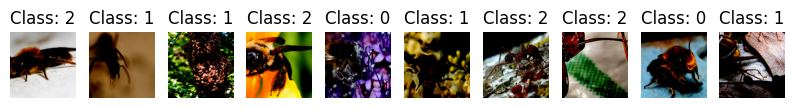

In [6]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
''' 6. 불러온 특정 모델에 대해 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train() # 모델을 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE) # 기존 정의한 장비에 할당
        label = label.to(DEVICE) # 기존 정의한 장비에 할당
        optimizer.zero_grad() # 기존 할당되어 있던 gradient 값 초기화
        output = model(image) # Forward propagation
        loss = criterion(output, label) # loss 계산
        loss.backward() # Backpropagation을 통해 계산된 gradient 값을 각 파라미터에 할당
        optimizer.step() # 파라미터 업데이트
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                  Epoch, batch_idx * len(image),
                  len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                  loss.item()))

In [8]:
''' 7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval() # 모델을 평가 상태로 지정
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): # 평가하는 단계에서 gradient를 통해 파라미터 값이 업데이트되는 현상을 방지
        for image, label in test_loader:
            image = image.to(DEVICE) # 기존 정의한 장비에 할당
            label = label.to(DEVICE) # 기존 정의한 장비에 할당
            output = model(image) # Forward propagation
            test_loss += criterion(output, label).item() # loss 누적
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item() 
            
    test_loss /= len(test_loader.dataset) # 평균 loss 계산
    test_accuracy = 100. * correct / len(test_loader.dataset) # 정확도 계산
    return test_loss, test_accuracy

In [9]:
import torchvision.models as models
model = models.resnet18(pretrained=False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
print(model)

In [11]:
for Epoch in range(1, EPOCHS + 1):
    train(model, dataloaders['train'], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders['val'])
    print("\nEPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

../aten/src/ATen/native/cuda/Loss.cu:257: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:257: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [8,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:257: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [17,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:257: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [21,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`